# Predicting Knowledge Level Using User Knowledge Data

A user knowledge model has the goal of improving conceptual understanding in users. Its system has the ability to adapt to a certain user’s individual learning ability, improving their competence in grasping new concepts. Therefore, creating a well built learning model is crucial in creating dynamic and automated learning environments. 

The following project uses a user knowledge modeling data set collected by Hamdi Tolga Kahraman (2013) to answer the following question:

**How high will somebody’s knowledge score be based on their study time, exam performance, and prerequisite knowledge?**

The data set contains 405 observations from participants who prepared for and took an exam on Electrical DC Machines. They took two exams: one on prerequisite material, and one on targeted material based on prerequisite material. It includes columns for the degree of study time and exam performance for both prerequisite knowledge and new knowledge topics, the degree of repetition, and the user’s knowledge level. The user knowledge level column has four categories: very low, low, middle, and high. No information about the age group or educational background of subjects was found. 


All columns are recognized as type double with the exception of the user knowledge level (character variable). The data appears to be already normalized since all values (except the user’s knowledge level) fit in the range of 0 and 1. The dataset is almost tidy - however there is a description of the data in an extra column, but the number data is tidy.

________________________________________________________________________________________________________________________

# *Data Analysis*
We begin by analyzing our data. First we load the libraries and set our seed.

In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(GGally)
library(cowplot)

set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Then, we will read our dataset from the web; we will clean and wrangle it into a tidy format. We will unselect the data description and two empty columns, rename columns and mutate the classification label to a factor. All predictor variables will be used to later determine which of them are appropriate. 

In [2]:
downloaded_data <- download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
                                "knowledge.xls")

user_knowledge_data <- read_excel("knowledge.xls", 
                                  sheet = 2) %>%  #data we want is on page 2 of the excel file
    select(-"...7", -"...8", -"Attribute Information:")  # unselect unnecessary columns

# rename columns
colnames(user_knowledge_data) <- c("targeted_study_time", 
                                   "repetition", 
                                   "prereq_study_time", 
                                   "prereq_exam_performance", 
                                   "targeted_exam_performance", 
                                   "understanding_level")

# change class label to factor 
user_knowledge_data <- user_knowledge_data %>%
    mutate(understanding_level = as_factor(understanding_level)) 

head(user_knowledge_data)

New names:
* `` -> ...7
* `` -> ...8



targeted_study_time,repetition,prereq_study_time,prereq_exam_performance,targeted_exam_performance,understanding_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


                                Table.1 User Knowledge Data
---

Now that the data is tidied, we can split it into training and testing sets. Prop values were not discussed in class, so a default 75% split will be used. The testing data set is put aside until the model is built.

In [3]:
set.seed(1)
knowledge_split <- initial_split(user_knowledge_data, prop = .75, strata = understanding_level)
knowledge_train <- training(knowledge_split)
knowledge_test <- testing(knowledge_split)

## Examining Our Data
Next, the training data is summarized in informative tables. These include:
- means, max, min of each predictor
- how many of each label exist in the data frame

In [4]:
knowledge_train_means <- knowledge_train %>%
    summarize(target_study_time_mean = mean(targeted_study_time),
          repetition_mean = mean(repetition),
          prereq_study_time_mean = mean(prereq_study_time),
          prereq_exam_performance_mean = mean(prereq_exam_performance),
          targeted_exam_performance_mean = mean(targeted_exam_performance)) 
knowledge_train_means

target_study_time_mean,repetition_mean,prereq_study_time_mean,prereq_exam_performance_mean,targeted_exam_performance_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3750154,0.3527385,0.4640769,0.4234872,0.4546821


                            Table.2 User Knowledge Data Predictor Means
---

For the mean table, the data appears to be well scaled since the means are all within a similar range. This suggests that we may not need to scale/center our data, although this will be done to ensure accuracy.

In [5]:
knowledge_train_max <- knowledge_train %>% 
    summarize(target_study_time_max = max(targeted_study_time),
          repetition_max = max(repetition),
          prereq_study_time_max = max(prereq_study_time),
          prereq_exam_performance_max = max(prereq_exam_performance),
          targeted_exam_performance_max = max(targeted_exam_performance)) 
knowledge_train_max

knowledge_train_min <- knowledge_train %>%
    summarize(target_study_time_min = min(targeted_study_time),
          repetition_min = min(repetition),
          prereq_study_time_min = min(prereq_study_time),
          prereq_exam_performance_min = min(prereq_exam_performance),
          targeted_exam_performance_min = min(targeted_exam_performance)) 
knowledge_train_min

target_study_time_max,repetition_max,prereq_study_time_max,prereq_exam_performance_max,targeted_exam_performance_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.99,0.9,0.95,0.99,0.93


target_study_time_min,repetition_min,prereq_study_time_min,prereq_exam_performance_min,targeted_exam_performance_min
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0


                        Table.3 User Knowledge Data Predictors Min & Max
---

The min/max values show the range of each predictor (0-0.99), and confirm that some of the participants indeed had very high or very low levels of understanding. 

In [6]:
knowledge_labels <- knowledge_train %>%
group_by(understanding_level) %>%
    summarize(count = n())
knowledge_labels

`summarise()` ungrouping output (override with `.groups` argument)



understanding_level,count
<fct>,<int>
very_low,20
High,47
Low,62
Middle,66


          Table.4 User Knowledge Data Understanding Level Count
---

Regarding the amount of observations in each category, it can be seen a small amount of participants scored very low. Additionally, a small group scored very high. The distributions of every category will help choose the appropriate K value. The K value should not be double our smallest category (very_low). Otherwise, the smallest category will never have enough k-nn "voting power".

## Visualizing Our Data
Next, we will use plots to observe trends between predictor variables. We will compare our predictors to each other and note how distinct the clusters of `understanding_level` are. Tighter clusters with more separation will make it easier for our KNN model to predict labels correctly. Thus, the more appropriate predictors will be in our final model. The strength of the cluster 'tightness', along with forward selection will help determine which predictors should be used in the final model.

In [1]:
options(repr.plot.width = 10, repr.plot.height = 12)

pairs <- knowledge_train %>%
    ggpairs(columns = 1:5, mapping=ggplot2::aes(colour = understanding_level)) +
        theme(legend.position = "bottom") +
        labs(tag = "Figure.1") +
        ggtitle("Predictor Combinations") +
        theme(text = element_text(size = 12))

pairs

ERROR: Error in knowledge_train %>% ggpairs(columns = 1:5, mapping = ggplot2::aes(colour = understanding_level)): could not find function "%>%"


**Legend**

Green: High

Purple: Middle

Cyan: Low

Red: Very Low

From the plot, it is visible that targeted_exam_performance should be included in our model, since all other predictors produce tightly clustered groups of `understanding_levels` in comparison. Furthermore, `prereq_exam_performance` and `targeted_exam_performance` form the tightest clustering. However, other predictors coupled with `targeted_exam_performance` form separate clusters in a similar manner. For now, we can be confident that both `prereq_exam_performance` and `targeted_exam_performance` should be used as predictors in our final model.

# Choosing Predictors with Forward Selection


To choose our final predictors, forward selection will be performed. It creates a model for every possible combination of predictors and compares the accuracies of each one. The combination of predictors that gives us the highest accuracy will be chosen.

### ****Step 1****
First, a tibble that stores our results will be created to begin forward selection. 

In [8]:
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


### ****Step 2****
Since the same specifications are used throughout the process, we will create it the beginning.

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

### ****Step 3****
Next, a 10-vold cross-validation object is created. A 10-fold is used instead of a 5-fold object since the dataset is relatively small.

In [10]:
set.seed(1)
user_vfold <- vfold_cv(knowledge_train, v = 10, strata = understanding_level)

### ****Step 4****
Since no forward selection exists in R, several things should be prepared. First we get the names of all the potential predictors, and store the total number of predictors.

In [11]:
names <- colnames(knowledge_train %>% select(-understanding_level))

In [12]:
n_total <- length(names)

The selected predictors should be stored.

In [13]:
selected <- c()

### ****Step 5****
Now forward selection is performed: we use a loop to iterate through all the unselected predictors to determine the ones that gives the highest accuracy, and store the results into the tibble we created earlier.

In [14]:
set.seed(1)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("understanding_level", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe <- recipe(as.formula(model_string), 
                              data = knowledge_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(user_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,understanding_level ~ targeted_exam_performance,0.8524896
2,understanding_level ~ targeted_exam_performance+prereq_exam_performance,0.9596032
3,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition,0.9384670
4,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition+targeted_study_time,0.8767502
5,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition+targeted_study_time+prereq_study_time,0.7860109


                     Table.5 Accuracy Based On Predictor Combinations
---

## Conclusion of Choosing Predictors
By comparing the accuracies, we can conclude that we should use `targeted_exam_performance` and `prerequisite_exam_performance` as our predictors, since these give the highest accuracy of ~96%. This perfectly matches what we had seen in our visualization earlier, with the tightly clustered groups when we plotted `targeted_exam_performance` and `prerequisite_exam_performance`
against each other.

## **Visualizing Our Results**

There are two ways that we will visualize the results of our final model.

Firstly, because we expect the accuracy of our model to be very high, and because our data set is quite small, we do not expect many observations from our testing set to be incorrectly predicted. We can thus create two plots, with the x and y axis as our two predictors: one with the observations colour-coded as their predicted class lable, and another with the observations colour-coded as their actual class labels. Then, we can simply circle the observations that the model got incorrect and discuss these inaccuracies.

Secondly, because we are interested in analyzing whether the model potentially leaned towards over- or under-predicting the knowledge level of our observations, we can use a confusion matrix to compare false positives and negatives. We can discuss whether a higher false prediction (i.e. predicting an incorrect `high` knowledge level for a `low` observation) or a lower false prediction (i.e. predicting an incorrect `low` knowledge level for a `high` observation) is more meaningful/has greater consequences.

## **Model Expectations**

Now that we have fully analyzed our data, we expect to find that students with higher prerequisite knowledge and exam score will be classified as having a higher knowledge level.     

# ***Our Final Classification Model***

Now that we know what predictors we are going to use - `targeted_exam_performance` and `prerequisite_exam_performance` - we can create our final model. Note that we use the training data throughout this process.


First of all, we will create a final recipe with these two predictors. As previously mentioned, we do not *need* to scale and center our data since our data appears to be standardized already, however, we will standardize it again to ensure we get the best possible results from our model. 

In [15]:
user_recipe_final <- recipe(understanding_level ~ prereq_exam_performance + targeted_exam_performance, data = knowledge_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

We will need a knn model specification as well, specifying `neighbors = tune()` since we will first be choosing our k value.

In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

To help us choose our k value, we will cross validate. So we create a 10-fold cross-validation model. Recall that we use a 10-fold because our dataset is small.

In [17]:
set.seed(1)
user_vfold <- vfold_cv(knowledge_train, v = 10, strata = understanding_level)

Now let's create a tibble with different k values. As discussed previously, the range of k value that we choose to test depends largely on the size of our smallest class label in our training data set.

Observe that our smallest class label is `very_low` with only 20 observations. This means that our k value must not *exceed* a value of 40, since any k above 40 would mean that the `very_low` class label will *never* have enough voting power - even if all 20 of the `very_low` observations are within the k nearest points, it would never achieve a majority vote. Our model would never predict the `very_low` category. 

To reduce the possibility of a 'tie', we will let our 'maximum-k-value-to-try' be 39 instead of 40. 

In [18]:
gridvals <- tibble(neighbors = seq(1,39))

Finally, we combine everything into a workflow and collect metrics on our model.

In [19]:
knn_results <- workflow() %>%
  add_recipe(user_recipe_final) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = user_vfold, grid = gridvals) %>%
  collect_metrics()

Filter for the accuracy metrics.

In [20]:
accuracies <- knn_results %>%
  filter(.metric == "accuracy")

Let us create a graph to visualize the relationship between K values and accuracies. This will help us choose our k value.

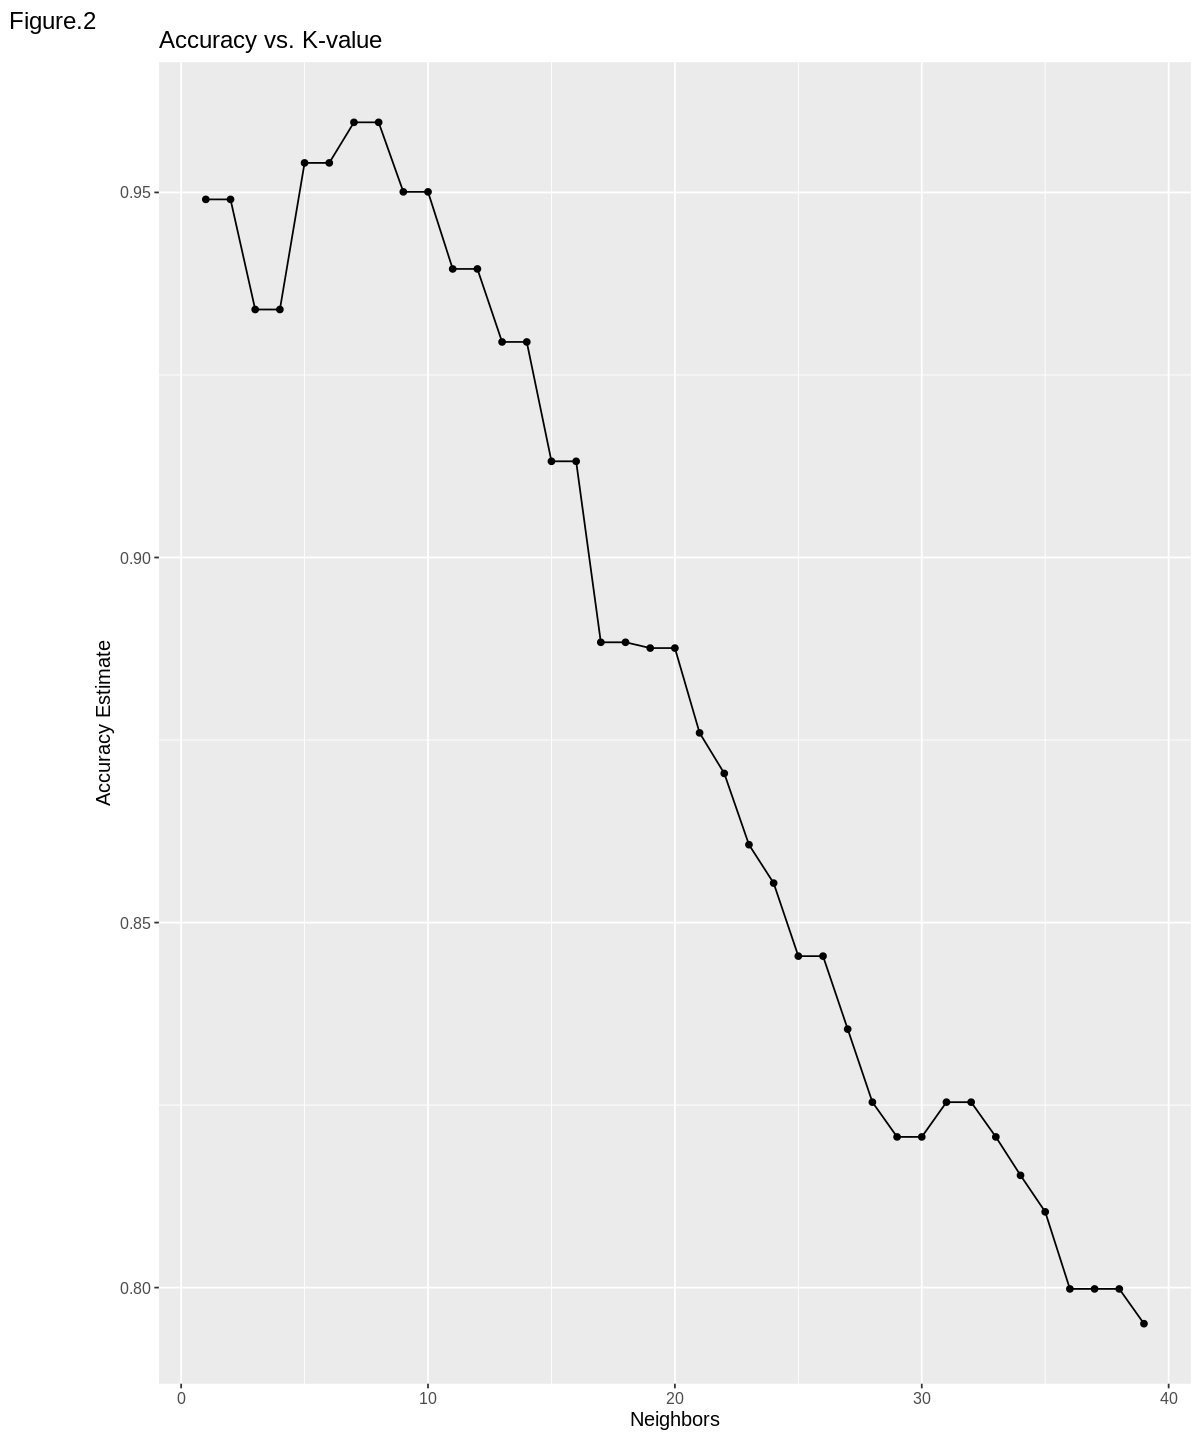

In [21]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  labs(tag = "Figure.2") +
  ggtitle("Accuracy vs. K-value") +
  theme(text = element_text(size = 12))

accuracy_vs_k

Now we can decide which k value to use. To do this, we will keep three principles in mind. Our k value must:
1. ensure we get rough optimal accuracy
2. be relatively stable (i.e. increasing or decreasing the k value by a small amount doesn't change the accuracy of our model too much)
3. not be too large

We can see that between k = 1 and k = 10, our k values are quite high, stable, and obviously not too large. We also note that the accuracy of our model decreases sharply after k = 10, so we do not want to choose our k value to be greater than 10. Furthermore, while there is a seemingly big dip in the k values from k = 2 to k = 5, note that the scale of the x axis means the dip looks much bigger than it truly is. So we know we want to look for a k in that area. 

Since the k values don't change too much within k = 1 and k = 10, we are free to choose a k that gives us the highest accuracy within this range. This value would be either k = 6 or k = 7. Because their accuracies are exactly the same, we then move to comparing how much the accuracies change when we increase and decrease the k value. 

Observe that the difference in accuracy between from k = 7 to k = 8 is greater than the difference in accuracy between k = 5 and k = 6. For this reason, we will choose **k = 6**. However, note that the differences between k = 6 and k = 7 are so incredibly minute that it likely would not impact our model significantly if we had chosen k = 7. 

# ***Our Final Classification Model With K = 6***

Now we should create a new specification model with k = 6.

In [22]:
user_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
  set_engine("kknn") %>%
  set_mode("classification")

We put the new specification into the workflow and reuse the previous recipe.

In [23]:
user_fit_final <- workflow() %>%
    add_model(user_spec_final) %>%
    add_recipe(user_recipe_final) %>%
    fit(knowledge_train)

Now let us predict the test set that we separated earlier. 

In [24]:
user_prediction <- user_fit_final %>%
    predict(knowledge_test) %>%
    bind_cols(knowledge_test)

Finally, let us view the accuracy of our prediction.

In [25]:
user_prediction_accuracy <-  user_prediction %>%
  metrics(truth = understanding_level, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

user_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9365079


    Table.6 Accuracy Of Optimized K Value
---

We will analyze the results of our classifiers after we have visualized our results also via plots and a confusion matrix. 

## Visualization of model results

Now we can visualize our results by plotting two graphs as previously described: one that classifies the observations by their predicted class, and one that classifies them by their actual class. We can then find the incorrectly classified points, circle them, and later analyze them.

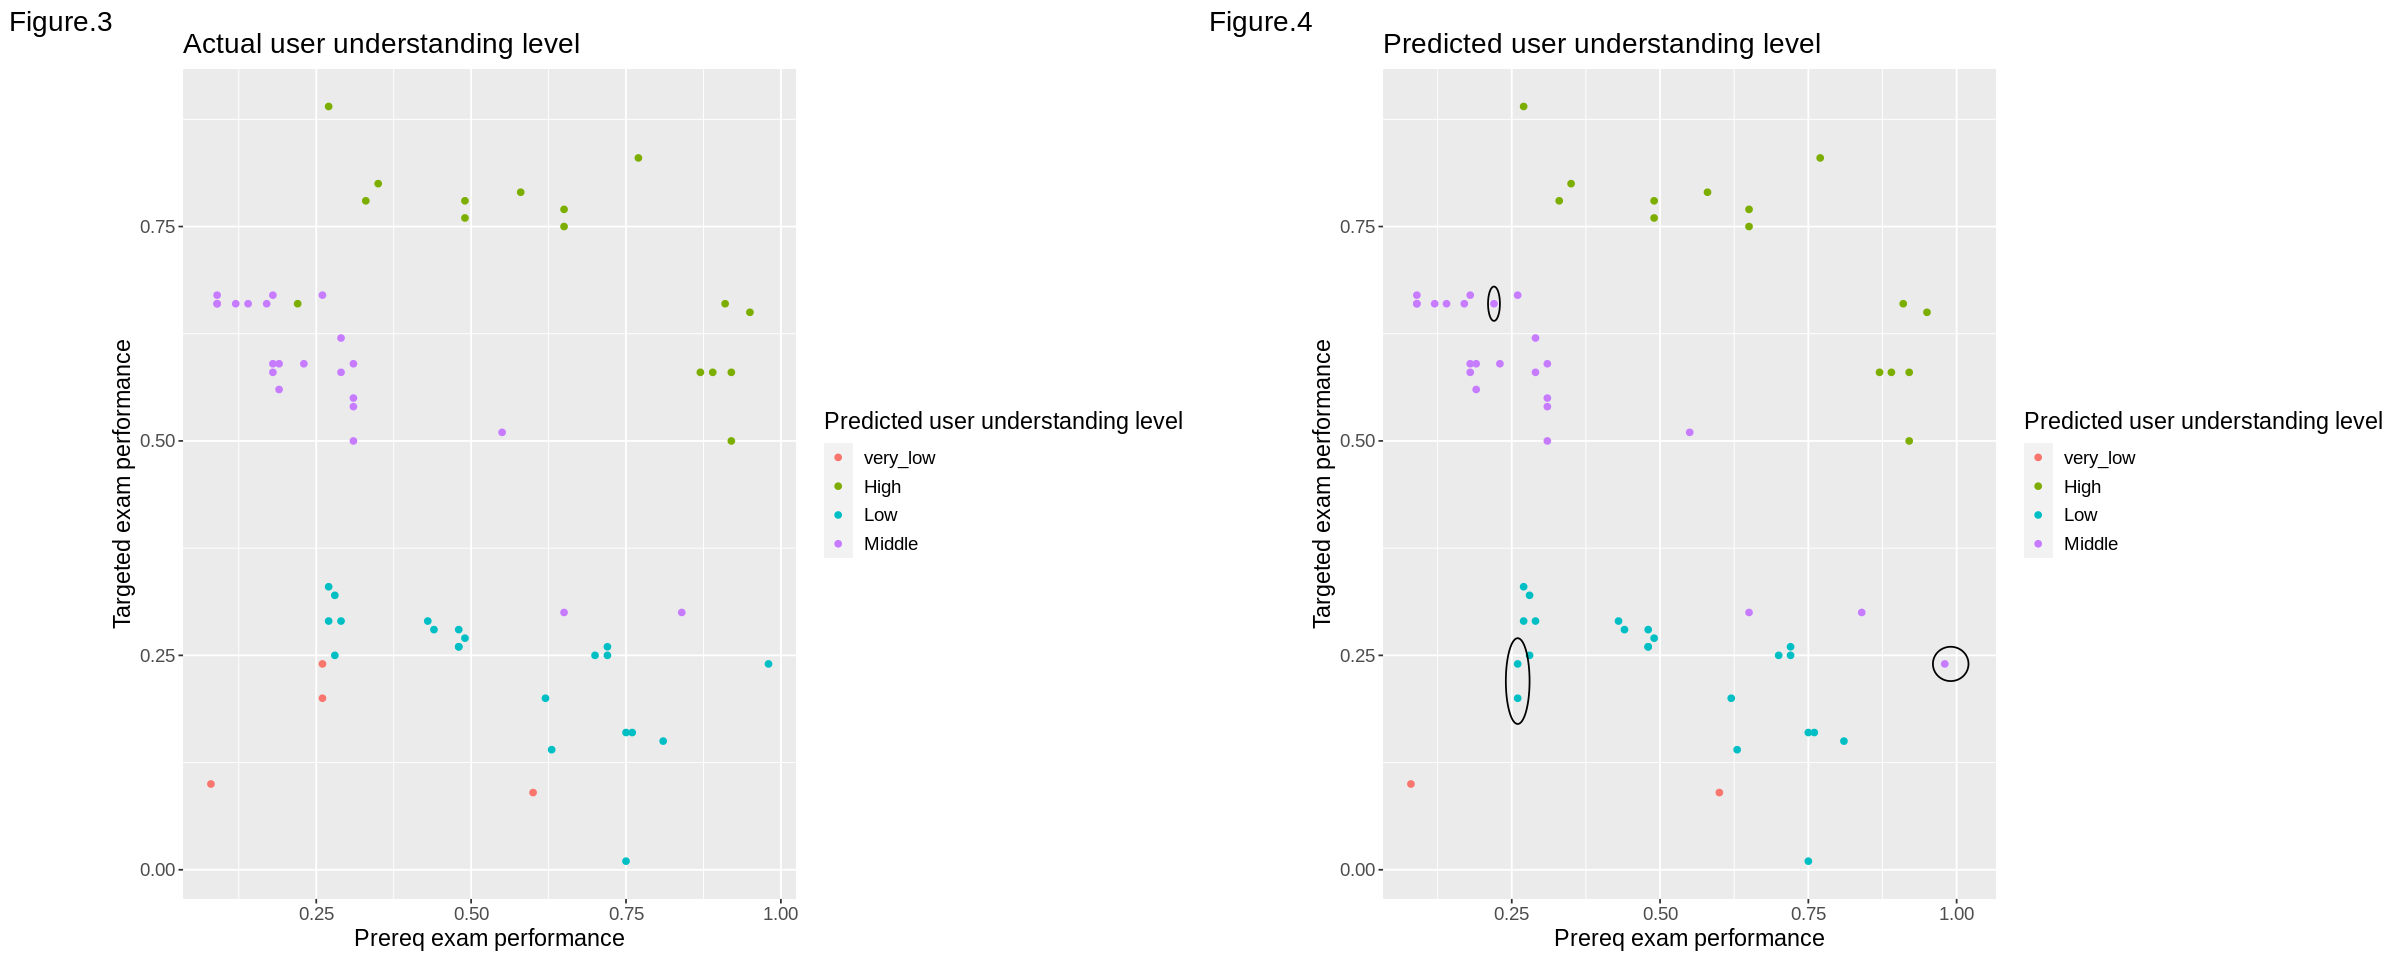

In [26]:
options(repr.plot.width = 20, repr.plot.height = 8)

# create vectors containing the coordinates of the incorrectly-labelled points to circle
upper_left_point <- c(0.22,0.66)
lower_left_points <- c(0.26,0.22)
lower_right_point <- c(0.99,0.24)

# predicted labels plot
user_predicted_plot <- user_prediction %>% 
    ggplot(aes(x = prereq_exam_performance, y = targeted_exam_performance, color = .pred_class)) +
        geom_point() + 
        labs(x = "Prereq exam performance", y = "Targeted exam performance", color = "Predicted user understanding level") +
        ggtitle("Predicted user understanding level") +
        # now we circle the incorrectly labelled points
        annotate("path", 
                     x=upper_left_point[1] + 0.01*cos(seq(0,2*pi,length.out=100)),
                     y=upper_left_point[2] + 0.02*sin(seq(0,2*pi,length.out=100))) +
         annotate("path", 
                     x=lower_left_points[1] + 0.02*cos(seq(0,2*pi,length.out=100)),
                     y=lower_left_points[2] + 0.05*sin(seq(0,2*pi,length.out=100))) +
        annotate("path", 
                     x=lower_right_point[1] + 0.03*cos(seq(0,2*pi,length.out=100)),
                     y=lower_right_point[2] + 0.02*sin(seq(0,2*pi,length.out=100))) +
        labs(tag = "Figure.4") +
        theme(text = element_text(size = 14))

# actual labels plot
user_class_plot <- user_prediction %>% 
    ggplot(aes(x = prereq_exam_performance, y = targeted_exam_performance, color = understanding_level)) +
        geom_point() + 
        labs(x = "Prereq exam performance", y = "Targeted exam performance", color = "Predicted user understanding level") +
        ggtitle("Actual user understanding level") +
        labs(tag = "Figure.3") +
        theme(text = element_text(size = 14))


plot_grid(user_class_plot, user_predicted_plot, nrow = 1)

## Confusion Matrix

The final tool in our toolkit for analyzing the results of our model is the confusion matrix. Let's create one.

In [27]:
user_mat <- user_prediction %>%
    conf_mat(truth = understanding_level, estimate = .pred_class)
user_mat

          Truth
Prediction very_low High Low Middle
  very_low        2    0   0      0
  High            0   15   0      0
  Low             2    0  20      0
  Middle          0    1   1     22

    Table.7 Confusion Matrix
---

# **Final Analysis**

Using three analysis tools (accuracy levels, two visualizations, and the confusion matrix) it is possible to analyze the model and its results.

As expected, we found that students with higher prerequisite knowledge and exam score will be classified as having a higher knowledge level.

These findings could highlight the importance of having a solid foundation of basic knowledge prior to learning more complex materials, and describe how the amount of time studied influences one’s knowledge level. Some future questions that our analysis could lead to are "what factors determine/influence exam performance?" and "what other study methods, other than the amount of time studied, can influence exam performance?". 

---
## Discussion - Model Accuracy 

The accuracy of our classifier is high (<90%). Although this might indicate incorrect procedure use upon closer inspection, this matches our expectations. 

Firstly, forward selection concluded that when two predictors were used, accuracy was at its highest (≈95%). This accuracy occured when a value of k = 6 was used Lastly, in our initial visualization we noticed extremely tight clustering between our `targeted_exam_performance` and `prerequisite_exam_performance` predictors. This visualization explains why our classifier accuracy is this high: a correctly chosen k value and tight clustering signifies that the model will be more efficient in classifying observations.

---

This accuracy is reflected in our two plots (note - there are only 4 labeled points).  Additionally, some of these points were difficult to label (except the upper left observation), as they were all on the border of two classes. The point might be an anomaly; it is surrounded by middle observations, and is incorrectly classified as high in the original dataset (thus it is incorrect).

---
The confusion matrix describes the type and amount of incorrect predictions made by the model. Since there are 4 different labels, it is impossible to classify the prediction types as “negative” or “positive”. Instead, they were grouped into two categories - 

1. **overestimate**: This occurs when the model predicts a *higher* than expected knowledge level for an observation.
2. **underestimate**: This is when the model predicts a *lower* than expected knowledge for an observation.
    
Given the context of our data, two conditions are used to analyze the contextual accuracy of the data:

### a. we consider **overestimates** to have "worse" consequences than underestimates. 

### b. the more knowledge levels a prediction "skips", the "worse" the consequences.

*Worse* consequences can be explained as having more severe “real-world” consequences.

Consider the following scenario: 

An online, self-learning module continuously takes input from the user to understand what their current knowledge level is based on previous exam scores. The module is building up an understanding of how well the student understands the topic. Say the module gives students quizzes. It chooses the difficulty of questions to present to the student based on what it thinks the student's understanding level is. Then we consider the following further scenarios: 

1. It is less favorable to give a student an extremely easy question than an easy one, since an overly easy question will not aid in learning progression. 
2. It is more favorable to five a student a difficult question than an overly difficult one, as an overly difficult question may discourage students, decreasing motivation. 
3. Regardless of model accuracy, simpler questions are more effective at reinforcing student understanding in comparison to difficult ones. More difficult questions might be outside of the student’s knowledge scope, while simpler questions test current knowledge.Thus, a smaller challenge will be more beneficial in helping students test their current knowledge, which outweighs the meager benefits of using difficult questions. 

Points 1 and 2 highlight point b above. Point 3 highlights point a. 


Another scenario-
An employer is open for hiring, and there are two candidates they must choose between. To ensure that the employee's knowledge level is up to par, it is more favorable to underestimate one's knowledge level, than to overestimate their knowledge level. Although this might seem unfair for employees presenting an accurate knowledge level, if one employee is presenting an inflated knowledge level, this precaution prevents them from being accepted.   

These two scenarios help us understand that it is better for our model to underestimate user knowledge to a small degree, versus overestimate user knowledge to a large degree. With that in mind, let us analyze our confusion matrix. 

In [28]:
user_mat

          Truth
Prediction very_low High Low Middle
  very_low        2    0   0      0
  High            0   15   0      0
  Low             2    0  20      0
  Middle          0    1   1     22

Our model made 4 incorrect classifications. Let's categorize them based on what we discussed above. 

- 3 observations were underestimated (two were supposed to be `low`, but predicted `very_low`; one was supposed to be `middle` but predicted `low`)
- 1 observation was overestimated (supposed to be `middle`, but predicted `high`)

Thus our model has performed well according to the context-based metrics we discussed. It has predicted more underestimates than overestimates, and each inaccurate prediction was only one category off (i.e. degree of inaccuracy is small). It's important to note that because our data set is so small, the significance of these findings is not incredibly high.

---
There are, however, some issues with our model that we can discuss also. 

Firstly, our data set is very small. Had we had access to a larger data set, it is likely that our model's accuracy would not be this high. There would be many more anomalies in our data like the point in the upper left corner of our plot. Secondly, our model unfortunately doesn't use the much greater variety of data that we have access to: the other predictors. It just so happens that the correlation between our class label and our predictors was strongest in the two predictors we picked, however, it would be interesting to see what other correlations could be drawn from the other predictors. 

# Conclusion

We can conclude that our model's accuracy is incredibly high, and also performed well in context-based scenarios. We also note, however, that this high accuracy is partially credited towards our small data set. 

# Citations

1. Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data. *Knowledge-Based Systems, 37*, 283-295.

2. Kahraman, H. T. (2009). Designing and Application of Web-Based Adaptive Intelligent Education System. Gazi University Ph. D. Thesis, Turkey, 1-156.
